# Домашнее задание #3. Шагающие человечки

Хей-хей, сегодня будем делать интересные штуки. На семинаре 7 мы обсудили и потыкали Mask R-CNN, в этом домашнем задании вам предстоит пойти дальше. 

Благодаря ему вы научитесь:
 - собирать Dataset для сегментационно-детекционных задач
 - обучать и тестить Mask R-CNN на своих классах
 - копаться в чужом коде (если ещё не умеете)
 - (бонусно) делать видео с результатами работы сети


 Да, прям настоящий Computer vision в этот раз!

В этом задании вы можете использовать одну из двух реализаций Mask R-CNN - стандартную из pytorch или [упомянутую](https://github.com/multimodallearning/pytorch-mask-rcnn) на семинаре. Выбор up to you, на оценку не повлияет. Только если вы берете git реализацию, код должен быть подгружен здесь же в ноутбуке (чтобы я могла всё воспроизвести без боли).

Укажите свой выбор явно тут:

## Часть 1. Копаемся в данных

На этот раз  у нас будет небольшой датасет из гуляющих людей (вы удивитесь насколько небольшой). Данные можно скачать [здесь](https://drive.google.com/file/d/11B511Gi1X60MtW1KVYY5Eq9jP0qQnJmR/view?usp=sharing).

Для того, чтобы учить сеть, нужен будет Dataloader, а значит и собственный Dataset. Чтобы собрать Dataset надо понять как выглядят данные и аннотация, а также какие данные понадобятся вашей сетке для обучения.

**Нужно чтобы данные лежали у вас архивом на Гуглдиске, тогда, поменяв директорию, ваши результаты можно будет воспроизвести и оценить.**

Обратите внимание, что единственная ваша аннотация - маски. Мы хотим учить Mask R-CNN, которой для обучения нужны и боксы для детекции, их надо получить самим.









In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Classroom/ML4_2020_OzonMasters/

/content/drive/My Drive/Classroom/ML4_2020_OzonMasters


In [ ]:
! unzip -q Pedestrians.zip -d data/

replace data/Pedestrians/imgs/000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### **Задание 1** (2 балла)
Разархивируйте данные, загрузите и посмотрите на фото и соответствующие им маски (соответствие происходит явно по имени ), напишите функцию, которая по маске высчитывает бокс, отрисуйте 4-5 фото с масками и боксами, как это было сделано на семинаре. Отсортируйте картинки по имени и разделите на train/test - в соотношении 4:1.

In [ ]:
import cv2
import torch
import random
import json
import os
import torchvision
import numpy as np

import colorsys
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import matplotlib.pyplot as ply
from skimage.measure import find_contours

import torch.utils.data as data

from PIL import Image, ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn as mask_rcnn

from tqdm import tqdm

In [ ]:
# !git clone https://github.com/pytorch/vision.git

In [ ]:
cd /content/drive/My Drive/Classroom/ML4_2020_OzonMasters/vision

/content/drive/My Drive/Classroom/ML4_2020_OzonMasters/vision


# Path declaration

In [ ]:
data_path = "/content/drive/My Drive/Classroom/ML4_2020_OzonMasters/data/"

### **Задание 2** (4 балла)

Посмотрите что принимает на вход та Mask R-CNN, которую вы выбрали. Напишите для нее Dataset.

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
#Заготовка датасета, можете менять её как удобно, главное чтобы работало

import numpy as np
import torch
from PIL import Image


class Pedestrian(data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # у нас нет аннотации, список картинок и масок надо подтянуть из root
        # self.imgs = imgs
        # self.masks = masks
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Pedestrians/imgs/"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "Pedestrians/masks/"))))

    def __getitem__(self, idx):
        # считываем картинку и маску с помощью PIL
        img_path = os.path.join(self.root, "Pedestrians/imgs/", self.imgs[idx])
        mask_path = os.path.join(self.root, "Pedestrians/masks/", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        #разделите одну маску с множеством объектов на несколько
        #таким образом что один канал - маска 1 instance

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        masks = mask == obj_ids[:, None, None]
        masks = 1 * (mask == obj_ids[:, None, None]).astype(np.uint8)

        # используйте функцию для вычисления бокса по маскe
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            # pos = np.where(masks[i])
            # xmin = np.min(pos[1])
            # xmax = np.max(pos[1])
            # ymin = np.min(pos[0])
            # ymax = np.max(pos[0])
            # boxes.append([xmin, ymin, xmax, ymax])
            x, y, w, h = tuple(self.get_box(masks[i, :, :]))

            boxes.append([x, y, x + w, y + h])

        #хоть лейбл один, он всё же нужен для обучения (для каждого инстанса нужна 1)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx], dtype=torch.int64)
        boxes = torch.tensor(boxes, dtype=torch.int64)
        masks = torch.tensor(masks, dtype=torch.uint8)
        area = boxes[:, 3] * boxes[:, 2]
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img= self.transforms(img)

        #пример как может выглядеть выход, можете оформить все targets в словарь
        return img, target

    def __len__(self):
        return len(self.imgs)

    @staticmethod
    def get_box(bin_mask):
        # bin_mask: an 8-bit single-channel image# !git clone https://github.com/pytorch/vision.git
        contours, _ = cv2.findContours(bin_mask, 
                                cv2.RETR_EXTERNAL, 
                                cv2.CHAIN_APPROX_SIMPLE)
        
        box = cv2.boundingRect(contours[0])
        # box = cv2.rectangle(np.array(img), (x,y), (x+w,y+h), (0,255,0), 2)

        return box 

## Train-test splitting

In [ ]:
cd /content/drive/My Drive/Classroom/ML4_2020_OzonMasters/vision/references/detection

/content/drive/My Drive/Classroom/ML4_2020_OzonMasters/vision/references/detection


In [ ]:
import utils 

dataset = Pedestrian(root=data_path, transforms=transform)

# split the dataset in train and test set
test_size = len(dataset) // 4
indices = torch.randperm(len(dataset)).tolist()
trainset = torch.utils.data.Subset(dataset, indices[:-test_size])
testset = torch.utils.data.Subset(dataset, indices[-test_size:])

# define training and validation data loaders
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn
)

## Plot some pictures

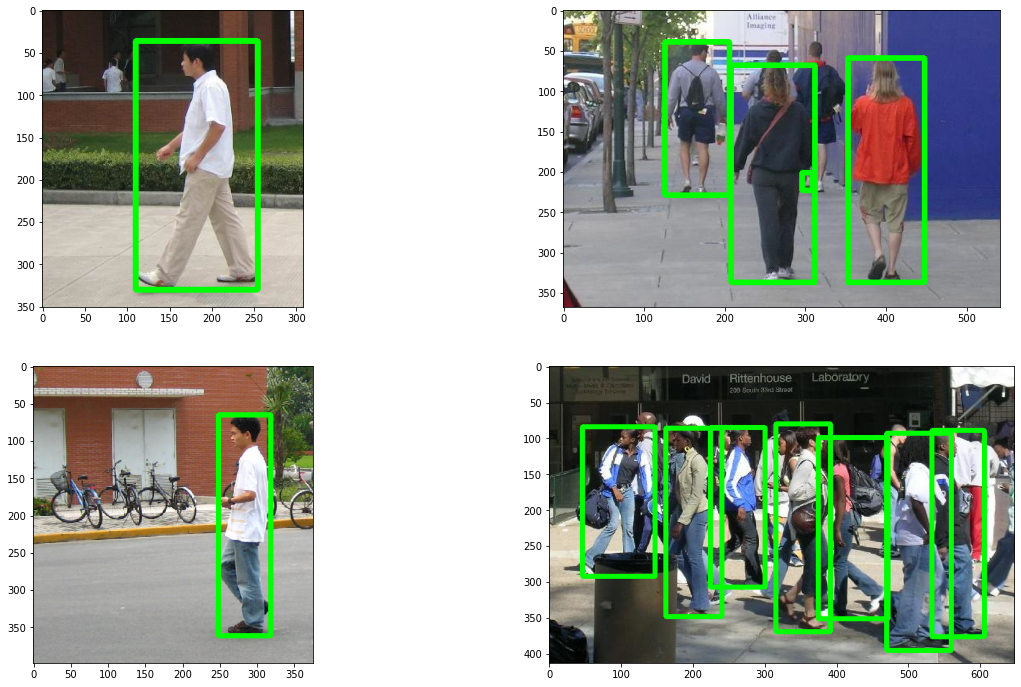

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

imgs, targets = iter(train_loader).next()
for i in range(len(imgs)):
    img = np.zeros((imgs[i].shape[1], imgs[i].shape[2], 3))
    img[:, :, 0] = imgs[i][0, :, :]
    img[:, :, 1] = imgs[i][1, :, :]
    img[:, :, 2] = imgs[i][2, :, :]

    target = targets[i]
    ax[0, i].imshow(img)
    for j in range(target["boxes"].shape[0]):
        x, y, xx, yy = tuple([k for k in target["boxes"][j, :].numpy()])
        rct = cv2.rectangle(img, (x,y), (xx,yy), (0,255,0), 5)
        rct[rct > 1] = rct[rct > 1] / 255
        ax[0, i].imshow(rct)

imgs, targets = iter(train_loader).next()
for i in range(len(imgs)):
    img = np.zeros((imgs[i].shape[1], imgs[i].shape[2], 3))
    img[:, :, 0] = imgs[i][0, :, :]
    img[:, :, 1] = imgs[i][1, :, :]
    img[:, :, 2] = imgs[i][2, :, :]

    target = targets[i]
    ax[1, i].imshow(img.astype('uint8'))

    for j in range(target["boxes"].shape[0]):
        x, y, xx,yy = tuple([k for k in target["boxes"][j, :].numpy()])
        rct = cv2.rectangle(img, (x,y), (xx,yy), (0,255,0), 5)
        rct[rct > 1] = rct[rct > 1] / 255
        ax[1, i].imshow(rct)

## Часть 2. Копаемся в Mask R-CNN

Это самая свободная в реализации часть - модифицируем и учим Mask R-CNN.

### **Задание 3**. (2 балла) 

Нужно взять Mask R-CNN и заменить у нее последний слои (помните, у нас всего 1 класс?)

### **Задание 4**. (12 баллов) 

1. Подотовьте код для обучения и тестирования. **Явно пропишите свои функции train, evaluate.**

Процедуры обучения и эвала можно посмотреть тут: [тык 1](https://github.com/pytorch/vision/blob/master/references/detection/engine.py), [тык 2](https://github.com/multimodallearning/pytorch-mask-rcnn/blob/master/model.py#L1736), [тык 3](https://github.com/pytorch/vision/blob/0467c9d74c9b34f91df905ed8cf8433de48d7fa5/references/detection/coco_eval.py#L19). Во многих репозиториях вы увидите, что процедуры написаны специально для [coco](https://cocodataset.org/#home) - это потому что это самый популярный датасет для детектирования и сегментации. 

2. Постарайтесь выйти на хорошее качество на test - **bbox AP@IoU=0.75 >=0.95**. И напишите в комментариях какими источниками пользовались.

3. Получите также результат детекции/сегментации для класса 1 (person) у первоначальной сети (не измененной и доученной вами) на том же pedestrians test сете. Получилось ли у вас улучшить показатели для этой задачи по сравнению с базовой моделью? 

Ещё раз почитать про AP [тут](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173) или на русском то же самое [тут](https://ml.i-neti.com/ru/2019/07/05/russkiy-map-mean-average-precision-v-detektsii-obektov/).

Да, нужно будет много покопаться в коде, но **вы справитесь**.


# The default network from torchvision

In [ ]:
def get_prediction(img, model, threshold_mask, threshold_obj, transform):
  output = model([transform(img).cuda()])[0]
  flag = output["scores"] >= threshold_obj
  pred_boxes = output["boxes"][flag].cpu().detach().numpy()
  pred_class = output["labels"][flag].cpu().detach().numpy()
  _pred_masks = output["masks"][flag].cpu().detach().numpy()
  pred_masks = _pred_masks >= threshold_mask
  return pred_masks, pred_boxes, pred_class

In [ ]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    # random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [ ]:
def visualize(image, boxes, masks, class_ids, class_names, scores=None, title="Segmented Pedestrian", figsize=(12, 12), ax=None,
                      show_mask=True, show_bbox=True, colors=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    """
    #сколько instance у нас
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[0] == class_ids.shape[0]

    #генерим случайные цвета для разных масок
    colors = colors or random_colors(N)

    _, ax = plt.subplots(1, figsize=figsize)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        #рисуем бокс
        x1, y1, x2, y2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, alpha=0.7,
                                 linestyle="dashed", edgecolor=color, facecolor='none')
            ax.add_patch(p)

        #подпись класса
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption, color='w', size=11, backgroundcolor="none")

        #рисуем маску
        mask = masks[i, :, :]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

    ax.imshow(masked_image.astype(np.uint8))
    plt.show()

In [ ]:
model = mask_rcnn(pretrained=True)
model = model.cuda()
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [ ]:
img = Image.open(data_path + "Pedestrians/imgs/" + "000.png")

In [ ]:
masks, boxes, classes = get_prediction(img, model, 0.4,  0.6, transform)

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


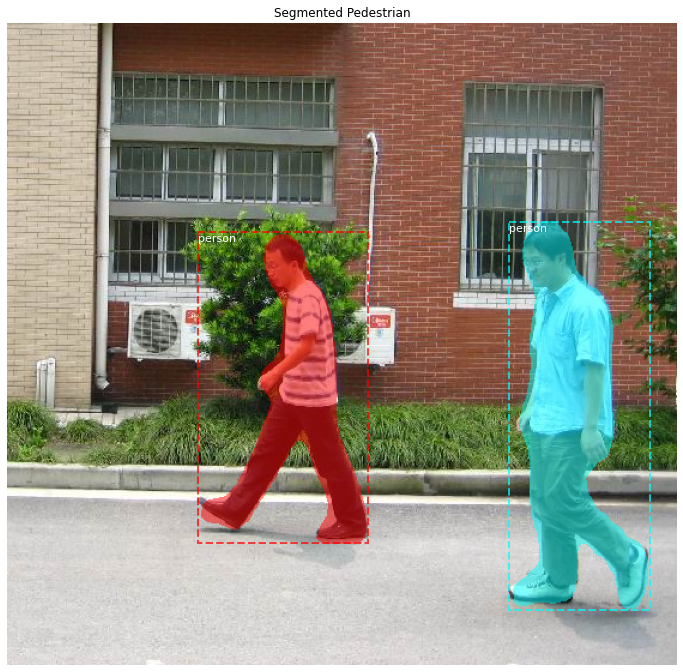

In [ ]:
img = cv2.imread(data_path + "Pedestrians/imgs/" + "000.png")
visualize(img[:, :, ::-1], boxes, masks, classes, class_names=["background", "person"])

# My model

## Download support library

In [ ]:
# !git clone https://github.com/pytorch/vision.git

In [ ]:
cd /content/drive/My Drive/Classroom/ML4_2020_OzonMasters/vision/references/detection

/content/drive/My Drive/Classroom/ML4_2020_OzonMasters/vision/references/detection


## Write suport function

In [ ]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = mask_rcnn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
# # Check th result
# model = mask_rcnn(pretrained=True)
# dataset = Pedestrian(root=data_path, transforms=transform)

# images,targets = next(iter(train_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections
# # For inference
# model.eval()
# # x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# # predictions = model(x)           # Returns predictions

In [ ]:
from engine import train_one_epoch, evaluate
import utils


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
    
    # lr_scheduler = ReduceLROnPlateau(
    #     optimizer, 
    #     factor=0.1, 
    #     patience=2, 
    #     threshold=0.1
    # )

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        metric_logger = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
        # update the learning rate
        # lr_scheduler.step(metric_logger.__getattr__("loss").avg)
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, test_loader, device=device)

    print("That's it!")
    return model

In [ ]:
model = main()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/57]  eta: 0:01:30  lr: 0.000094  loss: 3.3679 (3.3679)  loss_classifier: 0.4929 (0.4929)  loss_box_reg: 0.1835 (0.1835)  loss_mask: 2.6633 (2.6633)  loss_objectness: 0.0264 (0.0264)  loss_rpn_box_reg: 0.0019 (0.0019)  time: 1.5883  data: 0.3673  max mem: 2049
Epoch: [0]  [10/57]  eta: 0:00:34  lr: 0.000986  loss: 1.6597 (1.9475)  loss_classifier: 0.3761 (0.3456)  loss_box_reg: 0.2491 (0.2658)  loss_mask: 0.9564 (1.3024)  loss_objectness: 0.0232 (0.0294)  loss_rpn_box_reg: 0.0032 (0.0043)  time: 0.7238  data: 0.0385  max mem: 3033
Epoch: [0]  [20/57]  eta: 0:00:26  lr: 0.001878  loss: 0.7882 (1.3341)  loss_classifier: 0.2162 (0.2551)  loss_box_reg: 0.2451 (0.2584)  loss_mask: 0.3359 (0.7930)  loss_objectness: 0.0175 (0.0226)  loss_rpn_box_reg: 0.0040 (0.0051)  time: 0.6587  data: 0.0064  max mem: 3586
Epoch: [0]  [30/57]  eta: 0:00:18  lr: 0.002770  loss: 0.6407 (1.1045)  loss_classifier: 0.1117 (0.2041)  loss_box_reg: 0.2425 (0.2754)  loss_mask: 0.1977 (0.6004)  loss_ob

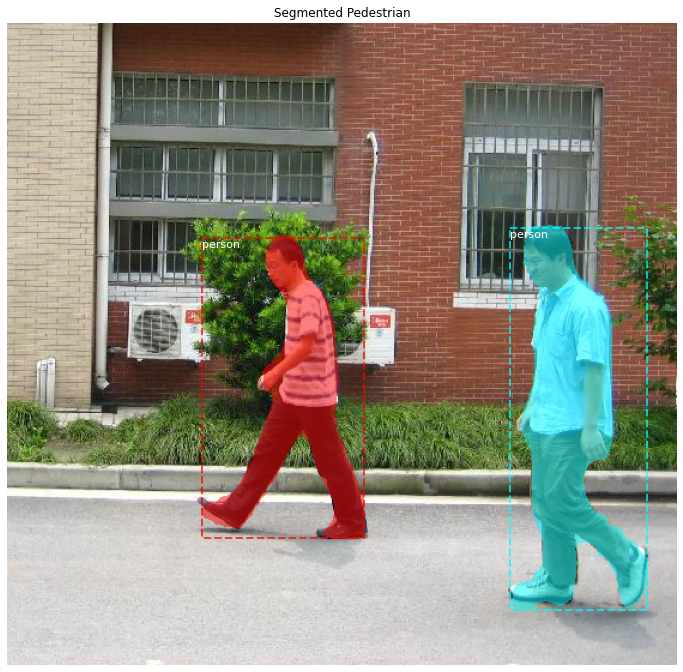

In [ ]:

img = Image.open(data_path + "Pedestrians/imgs/" + "000.png")
model.eval()
masks, boxes, classes = get_prediction(img, model, 0.4,  0.8, transform)
img = cv2.imread(data_path + "Pedestrians/imgs/" + "000.png")
visualize(img[:, :, ::-1], boxes, masks, classes, class_names=["background", "person"])

In [ ]:
torch.save(model.state_dict(), data_path + "my_model.pt")

## Часть 3. Копаемся с видео (это бонусная часть!)

Давайте теперь сделаем классный видос, чтобы все видели какие мы молодцы. 
Видео для теста живет тут: https://www.epfl.ch/labs/cvlab/data/data-pom-index-php/

Берем оттуда **Campus sequences - [Seq.1, cam. 1].**

### **Задание 5**. (6 баллов)

Пишем Dataset для видео. Впервые он будет иметь метод не get_item, а iter, так как по видео мы хотим пройти один раз и фрейм за фреймом отправлять в сетку, смотрите доки по IterableDataset [тут](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset). Можно использовать и обычный Dataset, но для get_item нам надо уметь выдергивать из видео фрейм по конкретному индексу, а для VideoCapture этот метод работает плохо (возможны неточные выдергивания и ваши визуализации полетят к чертям).

Так как это eval процедура, можете вообще не использовать Dataset и Dataloader, а читать последовательно кадры и оборачивать их в тензоры для сети. 

Далее прогоняем картинки через сетку и для кадров собираем результаты по маскам и детекциям (используйте в лоадере batch_size=1, num_workers=0 - иначе с VideoCapture могут возникнуть проблемы)

Пробегаем по видео ещё раз, рисуем на фреймах маски и боксы как и в 1 задании (цвет выберите один раз для всех масок чтобы каждый кадр он не мигал), собираем всё в видео - наслаждаемся. Видео сдайте вместе с заданием.


# Load model

In [ ]:
model = get_model_instance_segmentation(num_classes=2)
PATH = "/content/drive/My Drive/Classroom/ML4_2020_OzonMasters/data/my_model.pt"
model.load_state_dict(torch.load(PATH))
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

# Video

In [ ]:
# заготовка (можете не использовать, а написать по-своему)
class VideoSet(torch.utils.data.IterableDataset):
    """Dataset based on video file"""
    def __init__(self, root, transforms):
        self.cap = cv2.VideoCapture(root + "campus4-c1.avi")
        self.transforms = transforms

    def __iter__(self):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, 0) #поставили указатель начала чтения на самое начало
        frame_id = -1 

        while True:
            frame_id += 1
            status, image = self.cap.read()

            if not status:
                break
 
            if self.transforms is not None:
                image = self.transforms(image)

            yield (frame_id, image)

        #а ещё frame_id надо менять если id нужен

In [ ]:
def plot_mask_box(image, boxes, masks, class_ids, class_names, scores=None, ax=None,
                      show_mask=True, show_bbox=True, colors=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    """
    #сколько instance у нас
    # Number of instances
    if boxes.shape[0] == 0:
        ax.imshow(image.astype(np.uint8))
        return

    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[0] == class_ids.shape[0]

    #генерим случайные цвета для разных масок
    colors = colors or random_colors(N)


    # ax.axis('off')
    # ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        #рисуем бокс
        x1, y1, x2, y2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, alpha=0.7,
                                 linestyle="dashed", edgecolor=color, facecolor='none')
            ax.add_patch(p)

        #подпись класса
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption, color='w', size=11, backgroundcolor="none")

        #рисуем маску
        mask = masks[i, :, :]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

    ax.imshow(masked_image.astype(np.uint8))
    

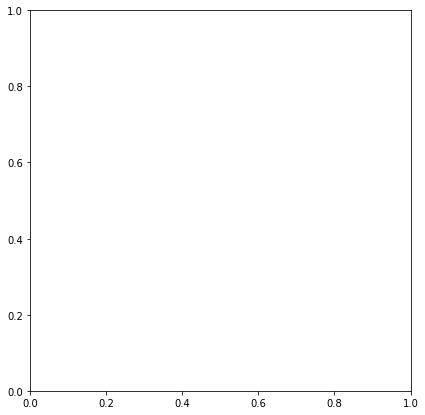

In [ ]:
dataset = VideoSet(root=data_path, transforms=transform)

model.cuda().eval()
fig, ax = plt.subplots(1, figsize=(12, 7))
for frame_id, image in dataset:
    img = transforms.ToPILImage()(image)
    masks, boxes, classes = get_prediction(img, model, 0.4,  0.8, transform)
    # print(frame_id, boxes.shape, masks.shape, classes.shape)
    colors = random_colors(1) * 10
    plot_mask_box(np.array(img), boxes, masks, classes, class_names=["background", "person"], 
                  ax=ax, colors=colors)
    fig.savefig(data_path + "Images/{:05}.png".format(frame_id))
    ax.clear()

## Make the video from the sequence of images

In [ ]:
import glob
 
img_array = []
size = (0, 0)
for filename in glob.glob(data_path + "Images/*.png"):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter(data_path + "detected_campus.avi", 
                      cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
# cd /content/drive/My Drive/Classroom/ML4_2020_OzonMasters/data

/content/drive/My Drive/Classroom/ML4_2020_OzonMasters/data


In [ ]:
# convert avi -> mp4
# !ffmpeg -i detected_campus.avi detected_campus.mp4

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open("/content/drive/My Drive/Classroom/ML4_2020_OzonMasters/data/detected_campus.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### **Задание 6**. (4 балла)

Вспоминаем, что вообще то мы делали instance segmentaion и знаем, что у нас ходят отдельные люди - сделайте простенький трекинг с матчингом боксов с соседних фреймов по IoU детекций.

Идея проста - если на фреймах N и N+1 IoU двух боксов > threshold, то считаем что трек остался тот же - и для него сохраняем цвет визуализации бокса с фрейма N, если нет - заводим новый цвет. И учитываем что бокс может сматчиться только с ОДНИМ боксом с предыдущего кадра. Что за IoU ещё раз смотрим [тут](https://medium.com/towards-artificial-intelligence/understanding-iou-metric-in-object-detection-1e5532f06a76).

Для тех же боксов и масок нарисуйте ещё одно видео - где каждый человек будет иметь **один** цвет **от начала до конца** своего присутствия в видео (фактически трекаться). 

Этот прекрасный видос тоже прикладывайте к заданию, я обязательно посмотрю.

In [ ]:
# def compute_iou(box, boxes, box_area, boxes_area):
#     """
#     Calculates IoU of the given box with the array of the given boxes.
    
#     Parameters
#     ----------

#     box: 1D vector [x1, y1, x2, y2]
#     boxes: [boxes_count, (x1, y1, x2, y2)]
#     box_area: float. the area of 'box'
#     boxes_area: array of length boxes_count.

#     Returns
#     -------
#     iou: float
    
#     Note: the areas are passed in rather than calculated here for
#           efficency. Calculate once in the caller to avoid duplicate work.
#     """
#     # Calculate intersection areas
#     y1 = np.maximum(box[1], boxes[:, 1])
#     y2 = np.minimum(box[3], boxes[:, 3])
#     x1 = np.maximum(box[0], boxes[:, 0])
#     x2 = np.minimum(box[2], boxes[:, 2])

#     intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
#     union = box_area + boxes_area[:] - intersection[:]
#     iou = intersection / union

#     return iou

# color_palette = random_colors(10)

# def get_colors(prev_colors, prev_boxes, boxes, threshold=0.85):
#     # if boxes.shape[0] == 0:
#     #     return prev_colors

#     N = boxes.shape[0] - len(prev_colors)
#     if N > 0:
#         add_colors = []
#         i = 0
#         for c in color_palette:
#             if c not in prev_colors:
#                 add_colors.append(c)
#                 i += 1

#             if i >= N:
#                 colors = prev_colors + add_colors
#                 break
#     elif N == 0:
#         colors = prev_colors.copy()
#     else:
#         colors = [0] * boxes.shape[0]

#     if not colors:
#         return colors

#     for i in range(prev_boxes.shape[0]):
#         x1, y1, x2, y2 = prev_boxes[i]
#         prev_box_area = (x2 - x1) * (y2 - y1)
#         boxes_area = (
#             (boxes[:, 2] - boxes[:, 0])
#             * (boxes[:, 3] - boxes[:, 1])
#         )
#         iou = compute_iou(prev_boxes[i], boxes, prev_box_area, boxes_area)
#         max_idx_iou = np.argmax(iou * (iou > threshold))

#         if np.any(iou > threshold):
#             colors[max_idx_iou] = prev_colors[i]
    
#     return colors


In [ ]:
# frame_id1, image1 = list(dataset)[376]
# frame_id2, image2 = list(dataset)[377]

In [ ]:
# prev_masks, prev_boxes, prev_classes = get_prediction(transforms.ToPILImage()(image1), model, 0.4,  0.8, transform)
# masks, boxes, classes = get_prediction(transforms.ToPILImage()(image2), model, 0.4,  0.8, transform)

In [ ]:
# prev_colors = color_palette[: prev_boxes.shape[0]]
# get_colors(prev_colors, prev_boxes, boxes, threshold=0.85)

[(1.0, 0.0, 0.0), (1.0, 0.6000000000000001, 0.0)]

In [ ]:
# dataset = VideoSet(root=data_path, transforms=transform)

# model.cuda().eval()
# fig, ax = plt.subplots(1, figsize=(12, 7))
# for frame_id, image in dataset:
#     img = transforms.ToPILImage()(image)
#     if frame_id == 0:
#         prev_masks, prev_boxes, prev_classes = get_prediction(img, model, 0.4,  0.8, transform)
#         prev_colors = color_palette[: prev_boxes.shape[0]]
#         plot_mask_box(np.array(img), prev_boxes, prev_masks, prev_classes, 
#                       class_names=["background", "person"], ax=ax, colors=prev_colors)
#     else:
#         masks, boxes, classes = get_prediction(img, model, 0.4,  0.8, transform)
#         if boxes.shape[0] == 0:
#             colors = []
#         else:
#             colors = get_colors(prev_colors, prev_boxes, boxes, threshold=0.4)
#             # print(frame_id, prev_colors, prev_boxes.shape[0], colors)
#             # print(frame_id, prev_boxes.shape[0])
        
#         plot_mask_box(np.array(img), boxes, masks, classes, 
#                       class_names=["background", "person"], ax=ax, colors=colors)
        
#         prev_masks = masks
#         prev_boxes = boxes 
#         prev_classes = classes 
#         prev_colors = colors

#     fig.savefig(data_path + "Images/{:05}.png".format(frame_id))
#     ax.clear()

# Make the video from the sequence of the images

In [ ]:
import glob
 
img_array = []
size = (0, 0)
for filename in sorted(glob.glob(data_path + "Images/*.png")):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter(data_path + "tracked_campus.avi", 
                      cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
cd /content/drive/My Drive/Classroom/ML4_2020_OzonMasters/data

/content/drive/My Drive/Classroom/ML4_2020_OzonMasters/data


In [ ]:
# convert avi -> mp4
# !ffmpeg -i tracked_campus.avi tracked_campus.mp4

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open("/content/drive/My Drive/Classroom/ML4_2020_OzonMasters/data/tracked_campus.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## **А вот и конец дз. Вы просто великолепны!**